In [1]:
%load_ext autoreload

In [92]:
import matplotlib.pyplot as plt
import mysql.connector as mysql
import numpy as np
import base64
import PIL
from PIL import Image as Image
#from IPython.display import Image
#import urllib.parse
import io
import re
from app.src.db import *
%autoreload 2

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.metrics.
from matplotlib import pyplot as plt
import numpy as np

import requests
from io import BytesIO
from PIL import Image, ImageFilter
import os
os.environ['KERAS_BACKEND']='tensorflow'

ImportError: cannot import name 'rsquare' from 'tensorflow.keras.metrics' (/home/andrew/anaconda3/lib/python3.7/site-packages/tensorflow/keras/metrics/__init__.py)

In [11]:
mydb = mysql.connect(
    host="127.0.0.1",
    port=49157,
    user="root",
    password="datascience",
    database="racer")

X, Y = getDataset(mydb, 6, 1)
print(X.shape)
print(Y.shape)

(3294, 2500)
(3294, 3)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2206, 2500)
(1088, 2500)
(2206, 3)
(1088, 3)


In [48]:
def coeff_determination(y_true, y_pred):
    print("coeff_determination")
    from keras import backend as K
    print("1coeff done")
    SS_res =  K.sum(K.square( y_true-y_pred ))
    print("2coeff done")
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    print("3coeff done")
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def my_r2_score(v_true, v_pred):
    ssres = np.sum(np.square(v_true - v_pred))
    sstot = np.sum(np.square(v_true - np.mean(v_true)))
    return 1 - ssres / sstot

In [181]:
def buildModel(X_train, y_train, X_test, y_test, inputScaler=1, epochs=40):
    model = Sequential()
    model.add(Flatten(input_shape=(2500,1)))
    model.add(Dense(25, activation="relu"))
    model.add(Dense(3))
    #adam vs. sgd; adam works better
    model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanSquaredError()])
    model.build()
    #model.summary()
    model.fit(X_train * inputScaler, y_train, epochs=40, validation_data=(X_test * inputScaler, y_test), verbose=0)
    
    y_train_predictions = model.predict(X_train * inputScaler)
    y_train_rsquared = my_r2_score(y_train_predictions, y_train)
    
    y_test_predictions = model.predict(X_test * inputScaler)
    y_test_rsquared = my_r2_score(y_test_predictions, y_test)
    
    print(f"inputScaler: {inputScaler}")
    print(f"Training R-Squared: {y_train_rsquared}")
    print(f"Test R-Squared: {y_test_rsquared}")
    return y_train_rsquared, y_test_rsquared

def buildModelSingleTask(X_train, y_train, X_test, y_test, inputScaler=1, epochs=40, filename=None):
    model = Sequential()
    model.add(Flatten(input_shape=(2500,1)))
    model.add(Dense(25, activation="relu")) # lets try an intermediary layer of 625?
    model.add(Dense(1))
    #adam vs. sgd; adam works better
    model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanSquaredError()])
    model.build()
    #model.summary()
    model.fit(X_train * inputScaler, y_train, epochs=epochs, validation_data=(X_test * inputScaler, y_test), verbose=1)
    
    y_train_predictions = model.predict(X_train * inputScaler)
    y_train_rsquared = my_r2_score(y_train_predictions, y_train)
    
    y_test_predictions = model.predict(X_test * inputScaler)
    y_test_rsquared = my_r2_score(y_test_predictions, y_test)
    
    print(f"y_train.shape: {y_train.shape}")
    print(f"y_train_predictions.shape: {y_train_predictions.shape}")
    print(f"y_test.shape: {y_test.shape}")
    print(f"y_test_predictions.shape: {y_test_predictions.shape}")
    print(f"inputScaler: {inputScaler}")
    print(f"Training R-Squared: {y_train_rsquared}")
    print(f"Test R-Squared: {y_test_rsquared}")
    
    y_train_position_predicted = model.predict(X_train/255)
    y_test_position_predicted = model.predict(X_test/255)
    print(y_train_position_predicted.shape)
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].scatter(x=y_train.reshape(-1,1), y=y_train_predictions[:,0])
    ax[1].scatter(x=y_test.reshape(-1,1), y=y_test_predictions[:,0])
    ax[0].set_title(f"training r^2={y_train_rsquared}")
    ax[0].set_ylabel("predicted positions")
    ax[1].set_title(f"test r^2={y_test_rsquared}")
    ax[0].set_xlabel("actual positions")
    ax[1].set_xlabel("actual positions")
    if filename != None:
        plt.savefig(filename)
    return y_train_rsquared, y_test_rsquared, model


def evaluateModel(X_train, y_train, X_test, y_test, builder, epoch_range, inputScaler=1):
    train_rsquared = []
    test_rsquared = []
    for epoch in epoch_range:
        train, test = builder(X_train, y_train, X_test, y_test, inputScaler=inputScaler, epochs=epoch)
        train_rsquared.append(train)
        test_rsquared.append(test)
        fig,ax = plt.subplots(1,1,figsize=(5,5))
        ax.plot(epochs[:len(train_rsquared)], train_rsquared,c='r')
        ax.plot(epochs[:len(train_rsquared)], test_rsquared,c='b')
        ax.set_ylim(0,1)
        plt.tight_layout()
        ax.set_title(f"epoch={epoch}")
        plt.show()
    return epoch_range, train_rsquared, test_rsquared

inputScaler: 1
Training R-Squared: 0.9883142003093717
Test R-Squared: 0.5398450440125314


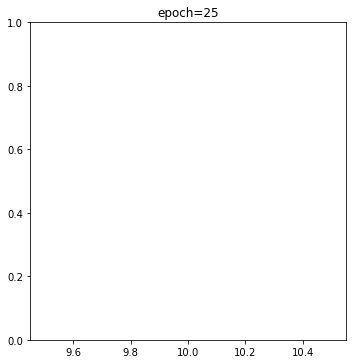

inputScaler: 1
Training R-Squared: 0.9848607313115174
Test R-Squared: 0.536368472172067


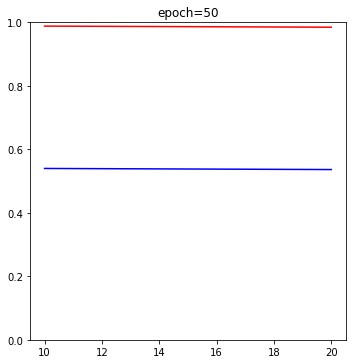

inputScaler: 1
Training R-Squared: 0.9870397335249109
Test R-Squared: 0.5044136816290143


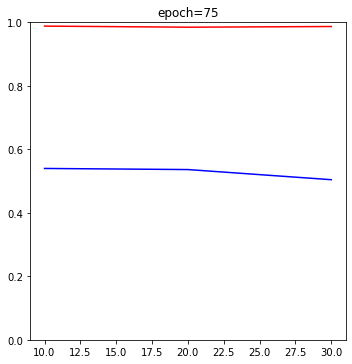

inputScaler: 1
Training R-Squared: 0.9897700272989305
Test R-Squared: 0.4941865369361368


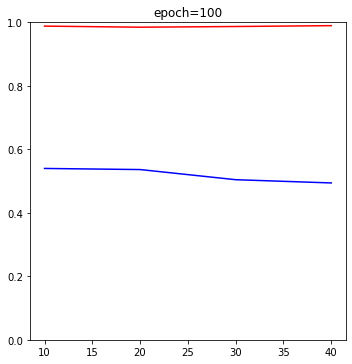

inputScaler: 1
Training R-Squared: 0.9798745973526116
Test R-Squared: 0.5300804827719579


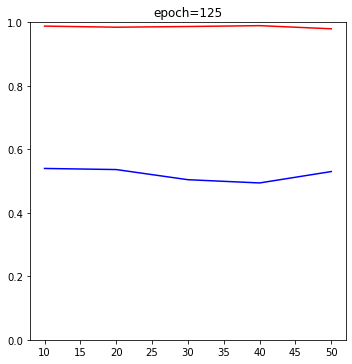

inputScaler: 1
Training R-Squared: 0.9852442128860822
Test R-Squared: 0.5492137330297912


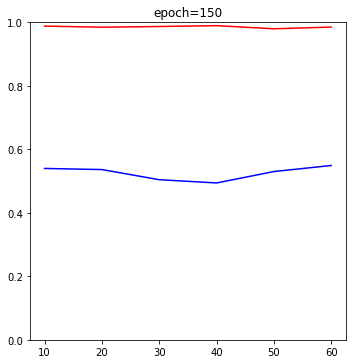

inputScaler: 1
Training R-Squared: 0.9507771057692039
Test R-Squared: 0.45980648766611865


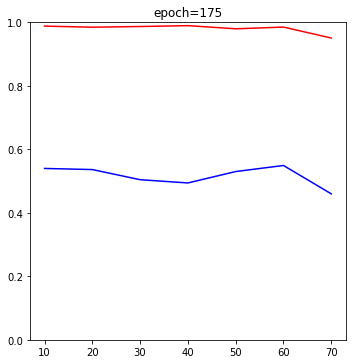

inputScaler: 1
Training R-Squared: 0.9894316774907631
Test R-Squared: 0.5459841380984276


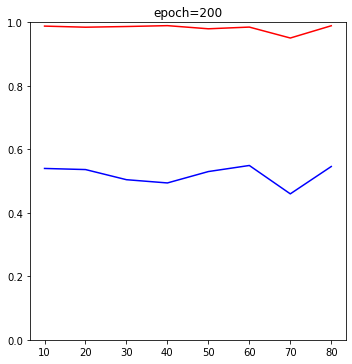

inputScaler: 1
Training R-Squared: 0.9875060959775801
Test R-Squared: 0.4851793649553102


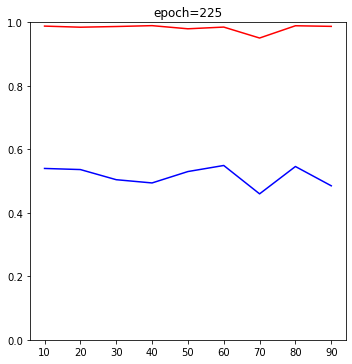

In [105]:
epochs, train_rsquared, test_rsquared = evaluateModel(X_train, y_train, X_test, y_test, buildModel, range(25,250,25))

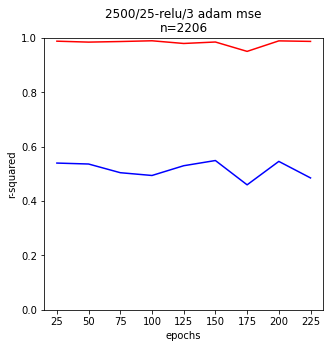

In [115]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(epochs, train_rsquared,c='r')
ax.plot(epochs, test_rsquared,c='b')
ax.set_title(f"2500/25-relu/3 adam mse\nn={X_train.shape[0]}")
ax.set_ylabel("r-squared")
ax.set_xlabel("epochs")
ax.set_ylim(0,1)
plt.savefig("alpha.v2.png")

(2206,)
(2206,)
(2206,)
(1088,)
(1088,)
(1088,)


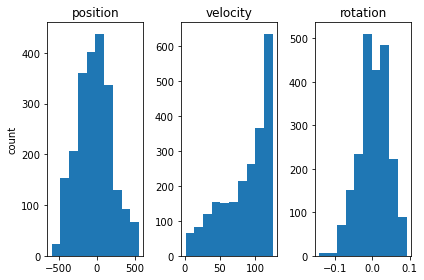

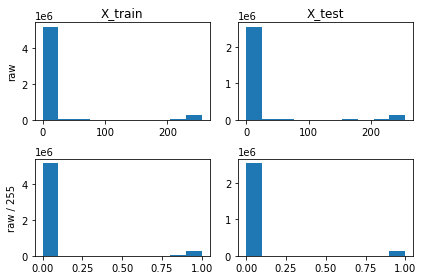

In [159]:
y_train_position = y_train[:,0]
y_train_velocity = y_train[:,1]
y_train_rotation = y_train[:,2]
print(y_train_position.shape)
print(y_train_velocity.shape)
print(y_train_rotation.shape)
y_test_position = y_test[:,0]
y_test_velocity = y_test[:,1]
y_test_rotation = y_test[:,2]
print(y_test_position.shape)
print(y_test_velocity.shape)
print(y_test_rotation.shape)

fig, ax = plt.subplots(1,3)
ax[0].hist(y_train_position)
ax[0].set_title("position")
ax[0].set_ylabel("count")
ax[1].hist(y_train_velocity)
ax[1].set_title("velocity")
ax[2].hist(y_train_rotation)
ax[2].set_title("rotation")
plt.tight_layout()
plt.savefig("y_eda.png")
plt.show()


fig, ax = plt.subplots(2,2)
ax[0,0].hist(X_train.reshape(-1,1))
ax[0,1].hist(X_test.reshape(-1,1))
ax[0,0].set_title("X_train")
ax[0,0].set_ylabel("raw")
ax[0,1].set_title("X_test")
ax[1,0].hist(X_train.reshape(-1,1)/255)
ax[1,0].set_ylabel("raw / 255")
ax[1,1].hist(X_test.reshape(-1,1)/255)
plt.tight_layout()
plt.savefig("x_eda.png")
plt.show()

Epoch 1/50
69/69 [==============================] - 0s 3ms/step - loss: 51847.1289 - mean_squared_error: 51847.1289 - val_loss: 52379.7188 - val_mean_squared_error: 52379.7188
Epoch 2/50
69/69 [==============================] - 0s 3ms/step - loss: 50843.6250 - mean_squared_error: 50843.6250 - val_loss: 51176.7578 - val_mean_squared_error: 51176.7578
Epoch 3/50
69/69 [==============================] - 0s 2ms/step - loss: 49363.4180 - mean_squared_error: 49363.4180 - val_loss: 49550.7500 - val_mean_squared_error: 49550.7500
Epoch 4/50
69/69 [==============================] - 0s 2ms/step - loss: 47578.6992 - mean_squared_error: 47578.6992 - val_loss: 47814.2812 - val_mean_squared_error: 47814.2812
Epoch 5/50
69/69 [==============================] - 0s 2ms/step - loss: 45626.9844 - mean_squared_error: 45626.9844 - val_loss: 46173.2109 - val_mean_squared_error: 46173.2109
Epoch 6/50
69/69 [==============================] - 0s 2ms/step - loss: 43488.1328 - mean_squared_error: 43488.1328 - va

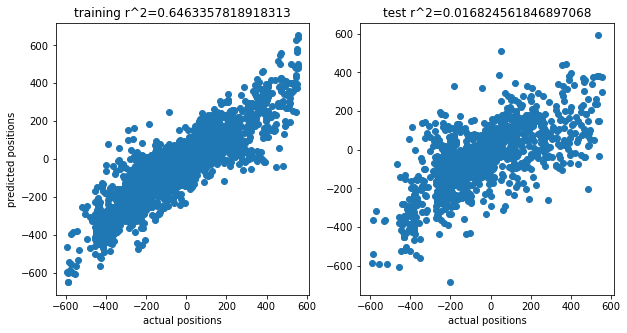

In [182]:
train_rsquared, test_rsquared, modelPosition  = buildModelSingleTask(X_train/255, y_train_position.reshape(-1,1), X_test/255, y_test_position.reshape(-1,1), inputScaler=1, epochs=50, filename="alpha.normalized.50epochs.png")

Epoch 1/50
69/69 [==============================] - 0s 3ms/step - loss: 39792.6211 - mean_squared_error: 39792.6211 - val_loss: 31318.4746 - val_mean_squared_error: 31318.4746
Epoch 2/50
69/69 [==============================] - 0s 2ms/step - loss: 20858.0449 - mean_squared_error: 20858.0449 - val_loss: 25249.5234 - val_mean_squared_error: 25249.5234
Epoch 3/50
69/69 [==============================] - 0s 1ms/step - loss: 13304.2803 - mean_squared_error: 13304.2803 - val_loss: 24121.4824 - val_mean_squared_error: 24121.4824
Epoch 4/50
69/69 [==============================] - 0s 1ms/step - loss: 8915.5107 - mean_squared_error: 8915.5107 - val_loss: 22859.7422 - val_mean_squared_error: 22859.7422
Epoch 5/50
69/69 [==============================] - 0s 1ms/step - loss: 6281.6724 - mean_squared_error: 6281.6724 - val_loss: 21301.5566 - val_mean_squared_error: 21301.5566
Epoch 6/50
69/69 [==============================] - 0s 2ms/step - loss: 4404.2578 - mean_squared_error: 4404.2578 - val_loss

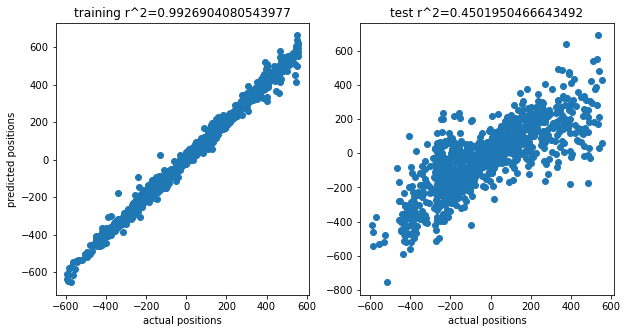

In [183]:
train_rsquared, test_rsquared, modelPosition  = buildModelSingleTask(X_train, y_train_position.reshape(-1,1), X_test, y_test_position.reshape(-1,1), inputScaler=1, epochs=50, filename="alpha.unnormalized.50epochs.png")

Epoch 1/500
69/69 [==============================] - 0s 2ms/step - loss: 51881.9844 - mean_squared_error: 51881.9844 - val_loss: 52413.8242 - val_mean_squared_error: 52413.8242
Epoch 2/500
69/69 [==============================] - 0s 1ms/step - loss: 50946.9844 - mean_squared_error: 50946.9844 - val_loss: 51305.2852 - val_mean_squared_error: 51305.2852
Epoch 3/500
69/69 [==============================] - 0s 1ms/step - loss: 49585.8398 - mean_squared_error: 49585.8398 - val_loss: 49807.3203 - val_mean_squared_error: 49807.3203
Epoch 4/500
69/69 [==============================] - 0s 2ms/step - loss: 47856.5742 - mean_squared_error: 47856.5742 - val_loss: 48164.1445 - val_mean_squared_error: 48164.1445
Epoch 5/500
69/69 [==============================] - 0s 1ms/step - loss: 45883.4180 - mean_squared_error: 45883.4180 - val_loss: 46235.7148 - val_mean_squared_error: 46235.7148
Epoch 6/500
69/69 [==============================] - 0s 1ms/step - loss: 43707.6641 - mean_squared_error: 43707.664

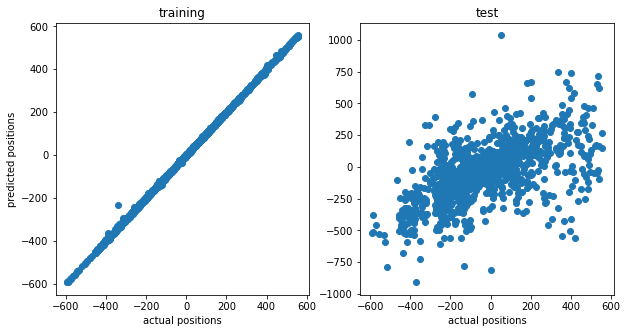

In [180]:
train_rsquared, test_rsquared, modelPosition  = buildModelSingleTask(X_train/255, y_train_position.reshape(-1,1), X_test/255, y_test_position.reshape(-1,1), inputScaler=1, epochs=500, filename="alpha.normalized.500epochs.png")